In [1]:
import csv
from xml.etree import ElementTree
import pandas as pd
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import os
from matplotlib.ticker import StrMethodFormatter
import statsmodels.api as sm
import scipy.stats as stats
from pyclustertend import hopkins, vat, assess_tendency_by_mean_metric_score
from sklearn.preprocessing import scale, MinMaxScaler, minmax_scale, RobustScaler,robust_scale
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import seaborn as sns

In [2]:
def get_data():
    file = "C:/Users/aprodea/work/metrics-tax-compare/merged/merged_filledna.csv"
    data = pd.read_csv(file, sep=';')
    return data

merged_data = get_data()
merged_data

Method   LOC   CC  NP   NV  \
0            GES_GRT.GES_GRTCoreModule.PreInitialize()  14.0  3.0   0  1.0   
1               GES_GRT.GES_GRTCoreModule.Initialize()   1.0  1.0   0  0.0   
2           GES_GRT.GES_GRTCoreModule.PostInitialize()   2.0  1.0   0  0.0   
3    GES_GRT.GES_GRTDomainServiceBase.GES_GRTDomain...   2.0  1.0   0  0.0   
4      GES_GRT.GES_GRTServiceBase.GES_GRTServiceBase()   2.0  1.0   0  0.0   
..                                                 ...   ...  ...  ..  ...   
799  GES_GRT.Web.App.Startup.AppBundleConfig.Regist...   8.0  1.0   1  0.0   
800  GES_GRT.Web.App.Startup.AppBundleConfig.AddApp...   1.0  3.0   2  0.0   
801  GES_GRT.Web.App.Startup.AppBundleConfig.AddApp...   1.0  6.0   2  0.0   
802  GES_GRT.Web.App.Startup.AppNavigationProvider....   2.0  1.0   1  0.0   
803  GES_GRT.Web.App.Startup.AppNavigationProvider....   1.0  1.0   1  1.0   

     NEST  Ca  Ce  NChg   NCall  
0     1.0   0   2   2.0     4.0  
1     0.0   0   0   1.0     4.0  
2     0.0   0   1   1.0     4.0  
3     0.0   5   0   1.0  3707.0  
4     0.0   4   0   1.0  2358.0  
..    ...  ..  ..   ...     ...  
799   0.0   1   3   4.0     4.0  
800   1.0   1   2   1.0     8.0  
801   1.0   1   2   1.0     8.0  
802   0.0   0   1  17.0     4.0  
803   0.0   1   0   2.0    92.0  

[804 rows x 10 columns]

In [3]:
list_columns = merged_data.columns.tolist()
list_columns.remove('Method')
list_columns

['LOC', 'CC', 'NP', 'NV', 'NEST', 'Ca', 'Ce', 'NChg', 'NCall']

In [4]:
scaled_data = merged_data.copy()

for col_name in list_columns:
    col = scaled_data[col_name]
    min_col, max_col = col.min(), col.max()
#     min_col = 0  # consider min as 0 to perserve the importance of values; eg LOC 25, 50 -> 0.5, 1 
#     print(col_name, min_col, max_col)
    scaled_data[col_name] = (col - min_col) / (max_col - min_col)
    
scaled_data

Method       LOC        CC  \
0            GES_GRT.GES_GRTCoreModule.PreInitialize()  0.141304  0.028571   
1               GES_GRT.GES_GRTCoreModule.Initialize()  0.000000  0.000000   
2           GES_GRT.GES_GRTCoreModule.PostInitialize()  0.010870  0.000000   
3    GES_GRT.GES_GRTDomainServiceBase.GES_GRTDomain...  0.010870  0.000000   
4      GES_GRT.GES_GRTServiceBase.GES_GRTServiceBase()  0.010870  0.000000   
..                                                 ...       ...       ...   
799  GES_GRT.Web.App.Startup.AppBundleConfig.Regist...  0.076087  0.000000   
800  GES_GRT.Web.App.Startup.AppBundleConfig.AddApp...  0.000000  0.028571   
801  GES_GRT.Web.App.Startup.AppBundleConfig.AddApp...  0.000000  0.071429   
802  GES_GRT.Web.App.Startup.AppNavigationProvider....  0.010870  0.000000   
803  GES_GRT.Web.App.Startup.AppNavigationProvider....  0.000000  0.000000   

           NP        NV  NEST        Ca        Ce      NChg     NCall  
0    0.000000  0.020408   0.1  0.000000  0.025641  0.026316  0.000115  
1    0.000000  0.000000   0.0  0.000000  0.000000  0.000000  0.000115  
2    0.000000  0.000000   0.0  0.000000  0.012821  0.000000  0.000115  
3    0.000000  0.000000   0.0  0.116279  0.000000  0.000000  0.106956  
4    0.000000  0.000000   0.0  0.093023  0.000000  0.000000  0.068034  
..        ...       ...   ...       ...       ...       ...       ...  
799  0.071429  0.000000   0.0  0.023256  0.038462  0.078947  0.000115  
800  0.142857  0.000000   0.1  0.023256  0.025641  0.000000  0.000231  
801  0.142857  0.000000   0.1  0.023256  0.025641  0.000000  0.000231  
802  0.071429  0.000000   0.0  0.000000  0.012821  0.421053  0.000115  
803  0.071429  0.020408   0.0  0.023256  0.000000  0.026316  0.002654  

[804 rows x 10 columns]

In [5]:
scaled_data[list_columns]

LOC        CC        NP        NV  NEST        Ca        Ce  \
0    0.141304  0.028571  0.000000  0.020408   0.1  0.000000  0.025641   
1    0.000000  0.000000  0.000000  0.000000   0.0  0.000000  0.000000   
2    0.010870  0.000000  0.000000  0.000000   0.0  0.000000  0.012821   
3    0.010870  0.000000  0.000000  0.000000   0.0  0.116279  0.000000   
4    0.010870  0.000000  0.000000  0.000000   0.0  0.093023  0.000000   
..        ...       ...       ...       ...   ...       ...       ...   
799  0.076087  0.000000  0.071429  0.000000   0.0  0.023256  0.038462   
800  0.000000  0.028571  0.142857  0.000000   0.1  0.023256  0.025641   
801  0.000000  0.071429  0.142857  0.000000   0.1  0.023256  0.025641   
802  0.010870  0.000000  0.071429  0.000000   0.0  0.000000  0.012821   
803  0.000000  0.000000  0.071429  0.020408   0.0  0.023256  0.000000   

         NChg     NCall  
0    0.026316  0.000115  
1    0.000000  0.000115  
2    0.000000  0.000115  
3    0.000000  0.106956  
4    0.000000  0.068034  
..        ...       ...  
799  0.078947  0.000115  
800  0.000000  0.000231  
801  0.000000  0.000231  
802  0.421053  0.000115  
803  0.026316  0.002654  

[804 rows x 9 columns]

In [6]:
def histogram_intersection(a, b):
    v = np.minimum(a, b).sum().round(decimals=1)
    return v
# scaled_data[list_columns].corr(method=histogram_intersection)
scaled_data[list_columns].corr(method='pearson')

LOC        CC        NP        NV      NEST        Ca        Ce  \
LOC    1.000000  0.818046  0.202876  0.735513  0.477668 -0.009790  0.683218   
CC     0.818046  1.000000  0.097643  0.676817  0.496175  0.012628  0.671144   
NP     0.202876  0.097643  1.000000  0.133015  0.042570 -0.018148  0.037268   
NV     0.735513  0.676817  0.133015  1.000000  0.644881  0.044936  0.487904   
NEST   0.477668  0.496175  0.042570  0.644881  1.000000 -0.013867  0.355599   
Ca    -0.009790  0.012628 -0.018148  0.044936 -0.013867  1.000000 -0.023237   
Ce     0.683218  0.671144  0.037268  0.487904  0.355599 -0.023237  1.000000   
NChg   0.521519  0.539215  0.076803  0.448622  0.268070  0.024080  0.572186   
NCall -0.058513 -0.038773  0.066878 -0.014726 -0.035725  0.034897 -0.064640   

           NChg     NCall  
LOC    0.521519 -0.058513  
CC     0.539215 -0.038773  
NP     0.076803  0.066878  
NV     0.448622 -0.014726  
NEST   0.268070 -0.035725  
Ca     0.024080  0.034897  
Ce     0.572186 -0.064640  
NChg   1.000000 -0.027705  
NCall -0.027705  1.000000

In [7]:
list_columns = ['LOC', 'NP', 'NEST', 'Ca', 'Ce', 'NChg']

winner:  ('diag', 6)


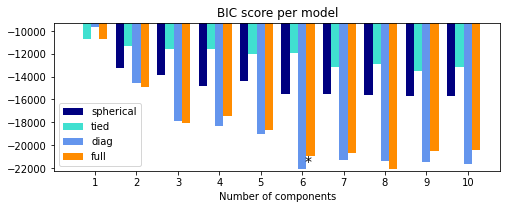

In [8]:
import itertools

from scipy import linalg
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn import mixture

# Number of samples per component
n_samples = scaled_data.shape[0]
X = scaled_data[list_columns].to_numpy()

lowest_bic = np.infty
bic = []
n_components_range = range(1, 11)
cv_types = ['spherical', 'tied', 'diag', 'full']
win='',0
for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a Gaussian mixture with EM
        gmm = mixture.GaussianMixture(n_components=n_components,
                                      covariance_type=cv_type,
                                      random_state=42)
        gmm.fit(X)
        bic.append(gmm.bic(X))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm
            win = cv_type, n_components

bic = np.array(bic)
color_iter = itertools.cycle(['navy', 'turquoise', 'cornflowerblue', 'darkorange'])
clf = best_gmm
bars = []

print("winner: ", win)

# Plot the BIC scores
plt.figure(figsize=(8, 6))
spl = plt.subplot(2, 1, 1)
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + .2 * (i - 2)
    bars.append(plt.bar(xpos, bic[i * len(n_components_range):
                                  (i + 1) * len(n_components_range)],
                        width=.2, color=color))
plt.xticks(n_components_range)
plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
plt.title('BIC score per model')
xpos = np.mod(bic.argmin(), len(n_components_range)) + .65 +\
    .2 * np.floor(bic.argmin() / len(n_components_range))
plt.text(xpos, bic.min() * 0.97 + .03 * bic.max(), '*', fontsize=14)
spl.set_xlabel('Number of components')
spl.legend([b[0] for b in bars], cv_types)

plt.show()

In [9]:
gmm = best_gmm
gmm.fit(scaled_data[list_columns])

GaussianMixture(covariance_type='diag', n_components=6, random_state=42)

In [10]:
gmm = mixture.GaussianMixture(n_components=3, covariance_type='full', random_state=42)

gmm.fit(scaled_data[list_columns])

GaussianMixture(n_components=3, random_state=42)

In [11]:
gmm.n_iter_

26

In [12]:
# True when convergence was reached in fit(), False otherwise.
gmm.converged_

True

In [13]:
# Lower bound value on the log-likelihood (of the training data with respect to the model) of the best fit of EM.
gmm.lower_bound_

11.602588832133359

In [14]:
# The weights of each mixture components.
gmm.weights_

array([0.10865287, 0.2864508 , 0.60489634])

In [15]:
groups = gmm.predict(scaled_data[list_columns])

In [16]:
scaled_data['CLevel'] = groups
scaled_data

Method       LOC        CC  \
0            GES_GRT.GES_GRTCoreModule.PreInitialize()  0.141304  0.028571   
1               GES_GRT.GES_GRTCoreModule.Initialize()  0.000000  0.000000   
2           GES_GRT.GES_GRTCoreModule.PostInitialize()  0.010870  0.000000   
3    GES_GRT.GES_GRTDomainServiceBase.GES_GRTDomain...  0.010870  0.000000   
4      GES_GRT.GES_GRTServiceBase.GES_GRTServiceBase()  0.010870  0.000000   
..                                                 ...       ...       ...   
799  GES_GRT.Web.App.Startup.AppBundleConfig.Regist...  0.076087  0.000000   
800  GES_GRT.Web.App.Startup.AppBundleConfig.AddApp...  0.000000  0.028571   
801  GES_GRT.Web.App.Startup.AppBundleConfig.AddApp...  0.000000  0.071429   
802  GES_GRT.Web.App.Startup.AppNavigationProvider....  0.010870  0.000000   
803  GES_GRT.Web.App.Startup.AppNavigationProvider....  0.000000  0.000000   

           NP        NV  NEST        Ca        Ce      NChg     NCall  CLevel  
0    0.000000  0.020408   0.1  0.000000  0.025641  0.026316  0.000115       1  
1    0.000000  0.000000   0.0  0.000000  0.000000  0.000000  0.000115       2  
2    0.000000  0.000000   0.0  0.000000  0.012821  0.000000  0.000115       2  
3    0.000000  0.000000   0.0  0.116279  0.000000  0.000000  0.106956       2  
4    0.000000  0.000000   0.0  0.093023  0.000000  0.000000  0.068034       2  
..        ...       ...   ...       ...       ...       ...       ...     ...  
799  0.071429  0.000000   0.0  0.023256  0.038462  0.078947  0.000115       1  
800  0.142857  0.000000   0.1  0.023256  0.025641  0.000000  0.000231       2  
801  0.142857  0.000000   0.1  0.023256  0.025641  0.000000  0.000231       2  
802  0.071429  0.000000   0.0  0.000000  0.012821  0.421053  0.000115       0  
803  0.071429  0.020408   0.0  0.023256  0.000000  0.026316  0.002654       1  

[804 rows x 11 columns]

In [17]:
first = scaled_data[scaled_data['CLevel'] == 0]
second = scaled_data[scaled_data['CLevel'] == 1] 
thrid = scaled_data[scaled_data['CLevel'] == 2]

print(len(first), len(second), len(thrid))

88 229 487


In [18]:
f_means = first[list_columns].mean(axis = 0)
f_mean = f_means.mean()
s_means = second[list_columns].mean(axis = 0)
s_mean = s_means.mean()
t_means = thrid[list_columns].mean(axis = 0)
t_mean = t_means.mean()

print(f_mean, s_mean, t_mean)

0.15180602837742554 0.07152072802341132 0.034493116861437446


In [19]:
fourth = scaled_data[scaled_data['CLevel'] == 3]
fifth = scaled_data[scaled_data['CLevel'] == 4]
sixth = scaled_data[scaled_data['CLevel'] == 5]
print(len(fourth), len(fifth), len(sixth))

fr_means = fourth[list_columns].mean(axis = 0)
fr_mean = fr_means.mean()
ft_means = fifth[list_columns].mean(axis = 0)
ft_mean = ft_means.mean()
six_means = sixth[list_columns].mean(axis = 0)
six_mean = six_means.mean()

print(fr_mean, ft_mean, six_mean)

0 0 0
nan nan nan


In [20]:
# means_dict = {f_mean: 0, s_mean: 1, t_mean: 2, fr_mean: 3, ft_mean: 4, six_mean: 5}
means_dict = {f_mean: 0, s_mean: 1, t_mean: 2}
means_list = [k  for  k in  means_dict.keys()]
print(means_list)
means_list.sort()
print(means_list)

[0.15180602837742554, 0.07152072802341132, 0.034493116861437446]
[0.034493116861437446, 0.07152072802341132, 0.15180602837742554]


In [21]:
def to_string_label(value):
    if value == means_dict[means_list[0]]:
        return "low"
    elif value == means_dict[means_list[1]]:
        return "regular"
    if value == means_dict[means_list[2]]:
        return "high"
scaled_data['CLevelLbl'] = scaled_data['CLevel'].apply(to_string_label)
scaled_data

Method       LOC        CC  \
0            GES_GRT.GES_GRTCoreModule.PreInitialize()  0.141304  0.028571   
1               GES_GRT.GES_GRTCoreModule.Initialize()  0.000000  0.000000   
2           GES_GRT.GES_GRTCoreModule.PostInitialize()  0.010870  0.000000   
3    GES_GRT.GES_GRTDomainServiceBase.GES_GRTDomain...  0.010870  0.000000   
4      GES_GRT.GES_GRTServiceBase.GES_GRTServiceBase()  0.010870  0.000000   
..                                                 ...       ...       ...   
799  GES_GRT.Web.App.Startup.AppBundleConfig.Regist...  0.076087  0.000000   
800  GES_GRT.Web.App.Startup.AppBundleConfig.AddApp...  0.000000  0.028571   
801  GES_GRT.Web.App.Startup.AppBundleConfig.AddApp...  0.000000  0.071429   
802  GES_GRT.Web.App.Startup.AppNavigationProvider....  0.010870  0.000000   
803  GES_GRT.Web.App.Startup.AppNavigationProvider....  0.000000  0.000000   

           NP        NV  NEST        Ca        Ce      NChg     NCall  CLevel  \
0    0.000000  0.020408   0.1  0.000000  0.025641  0.026316  0.000115       1   
1    0.000000  0.000000   0.0  0.000000  0.000000  0.000000  0.000115       2   
2    0.000000  0.000000   0.0  0.000000  0.012821  0.000000  0.000115       2   
3    0.000000  0.000000   0.0  0.116279  0.000000  0.000000  0.106956       2   
4    0.000000  0.000000   0.0  0.093023  0.000000  0.000000  0.068034       2   
..        ...       ...   ...       ...       ...       ...       ...     ...   
799  0.071429  0.000000   0.0  0.023256  0.038462  0.078947  0.000115       1   
800  0.142857  0.000000   0.1  0.023256  0.025641  0.000000  0.000231       2   
801  0.142857  0.000000   0.1  0.023256  0.025641  0.000000  0.000231       2   
802  0.071429  0.000000   0.0  0.000000  0.012821  0.421053  0.000115       0   
803  0.071429  0.020408   0.0  0.023256  0.000000  0.026316  0.002654       1   

    CLevelLbl  
0     regular  
1         low  
2         low  
3         low  
4         low  
..        ...  
799   regular  
800       low  
801       low  
802      high  
803   regular  

[804 rows x 12 columns]

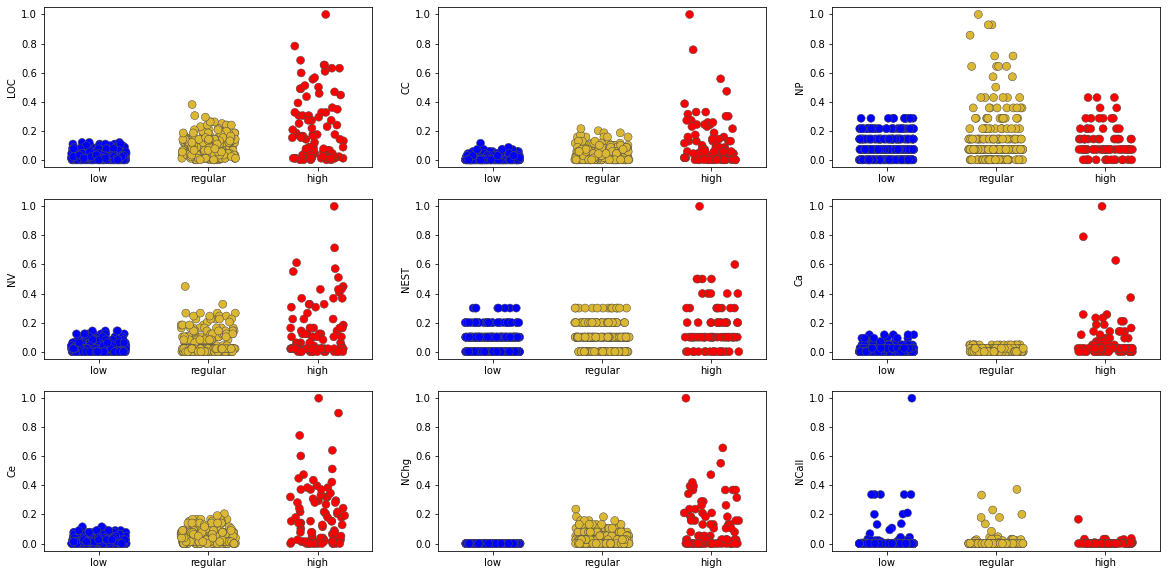

In [22]:
list_columns = ['LOC', 'CC', 'NP', 'NV', 'NEST', 'Ca', 'Ce', 'NChg', 'NCall']

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20,10))
ax = axes.flatten()
for i in range(len(list_columns)):
    col_name = list_columns[i]
    sns.stripplot(data=scaled_data, x='CLevelLbl', y=col_name, 
#                   hue='CLevelLbl', 
                  palette={'low':'blue', 'regular':'#DCB732', 'high':'red'},
                  jitter=0.25, size=8, ax=ax[i], linewidth=.5,
                  order=["low", "regular", "high"])
    ax[i].set_ylabel(col_name)
    ax[i].set_xlabel("")

plt.show()

In [23]:
df = scaled_data.copy()
list_columns = ['LOC', 'CC', 'NP', 'NV', 'NEST', 'Ca', 'Ce', 'NChg', 'NCall']
# df = df.stack()
df = pd.melt(df, id_vars=['Method', 'CLevelLbl'], value_vars=list_columns)
df

Method CLevelLbl variable  \
0             GES_GRT.GES_GRTCoreModule.PreInitialize()   regular      LOC   
1                GES_GRT.GES_GRTCoreModule.Initialize()       low      LOC   
2            GES_GRT.GES_GRTCoreModule.PostInitialize()       low      LOC   
3     GES_GRT.GES_GRTDomainServiceBase.GES_GRTDomain...       low      LOC   
4       GES_GRT.GES_GRTServiceBase.GES_GRTServiceBase()       low      LOC   
...                                                 ...       ...      ...   
7231  GES_GRT.Web.App.Startup.AppBundleConfig.Regist...   regular    NCall   
7232  GES_GRT.Web.App.Startup.AppBundleConfig.AddApp...       low    NCall   
7233  GES_GRT.Web.App.Startup.AppBundleConfig.AddApp...       low    NCall   
7234  GES_GRT.Web.App.Startup.AppNavigationProvider....      high    NCall   
7235  GES_GRT.Web.App.Startup.AppNavigationProvider....   regular    NCall   

         value  
0     0.141304  
1     0.000000  
2     0.010870  
3     0.010870  
4     0.010870  
...        ...  
7231  0.000115  
7232  0.000231  
7233  0.000231  
7234  0.000115  
7235  0.002654  

[7236 rows x 4 columns]

In [ ]:
fig, ax = plt.subplots(figsize=(16,10), dpi= 80)
sns.stripplot(data=df, x='variable', y='value', hue='CLevelLbl',
              palette={'low':'blue', 'regular':'#DCB732', 'high':'red'},
              hue_order=["low", "regular", "high"],
              jitter=0.25, size=8, ax=ax, linewidth=.5, dodge=True)

plt.show()

In [ ]:
# sns.set_theme(style="ticks")
fig, ax = plt.subplots(figsize=(16,10), dpi= 80)

sns.boxplot(data=df, x='variable', y='value', hue='CLevelLbl',
            palette={'low':'blue', 'regular':'#DCB732', 'high':'red'},
            hue_order=["low", "regular", "high"],
            )

# sns.stripplot(data=df, x='variable', y='value', hue='CLevelLbl',
#               palette={'low':'blue', 'regular':'#DCB732', 'high':'red'},
#               hue_order=["low", "regular", "high"],
#               jitter=0.25, size=8, linewidth=.5, dodge=True)

ax.xaxis.grid(True)
ax.set(ylabel="")
sns.despine(trim=True, left=True)
# plt.show()

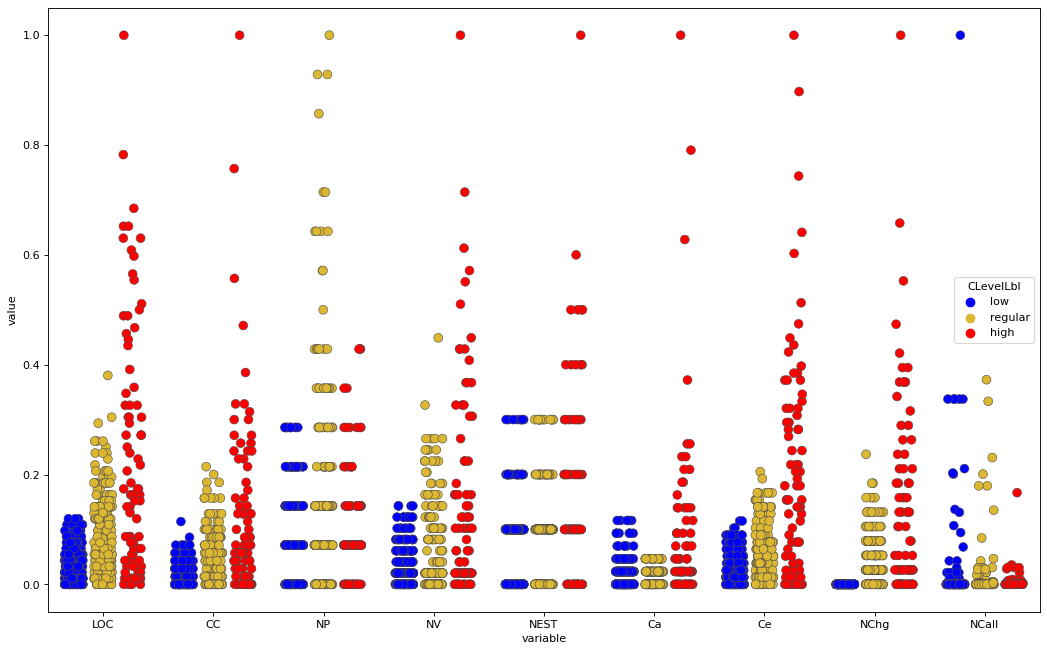

In [24]:
merged_data['CLevel'] = groups
merged_data

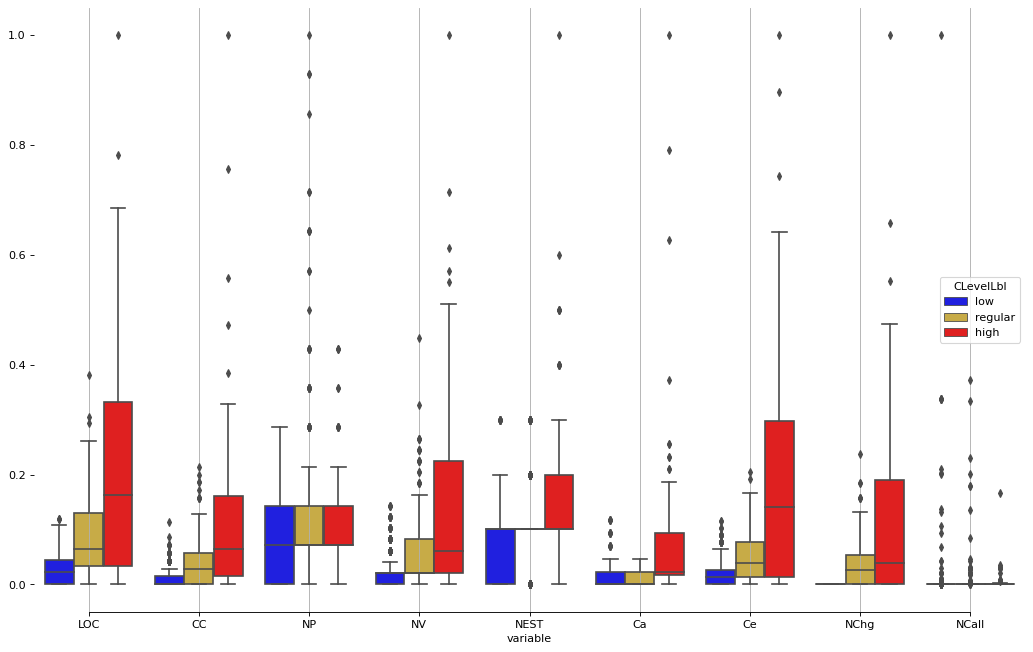

In [25]:
# sns.set_theme(style="ticks")
fig, ax = plt.subplots(figsize=(16,10), dpi= 80)

sns.boxplot(data=df, x='variable', y='value', hue='CLevelLbl',
            palette={'low':'blue', 'regular':'#DCB732', 'high':'red'},
            hue_order=["low", "regular", "high"],
            )

# sns.stripplot(data=df, x='variable', y='value', hue='CLevelLbl',
#               palette={'low':'blue', 'regular':'#DCB732', 'high':'red'},
#               hue_order=["low", "regular", "high"],
#               jitter=0.25, size=8, linewidth=.5, dodge=True)

ax.xaxis.grid(True)
ax.set(ylabel="")
sns.despine(trim=True, left=True)
# plt.show()

In [26]:
merged_data['CLevel'] = groups
merged_data

Method   LOC   CC  NP   NV  \
0            GES_GRT.GES_GRTCoreModule.PreInitialize()  14.0  3.0   0  1.0   
1               GES_GRT.GES_GRTCoreModule.Initialize()   1.0  1.0   0  0.0   
2           GES_GRT.GES_GRTCoreModule.PostInitialize()   2.0  1.0   0  0.0   
3    GES_GRT.GES_GRTDomainServiceBase.GES_GRTDomain...   2.0  1.0   0  0.0   
4      GES_GRT.GES_GRTServiceBase.GES_GRTServiceBase()   2.0  1.0   0  0.0   
..                                                 ...   ...  ...  ..  ...   
799  GES_GRT.Web.App.Startup.AppBundleConfig.Regist...   8.0  1.0   1  0.0   
800  GES_GRT.Web.App.Startup.AppBundleConfig.AddApp...   1.0  3.0   2  0.0   
801  GES_GRT.Web.App.Startup.AppBundleConfig.AddApp...   1.0  6.0   2  0.0   
802  GES_GRT.Web.App.Startup.AppNavigationProvider....   2.0  1.0   1  0.0   
803  GES_GRT.Web.App.Startup.AppNavigationProvider....   1.0  1.0   1  1.0   

     NEST  Ca  Ce  NChg   NCall  CLevel  
0     1.0   0   2   2.0     4.0       1  
1     0.0   0   0   1.0     4.0       2  
2     0.0   0   1   1.0     4.0       2  
3     0.0   5   0   1.0  3707.0       2  
4     0.0   4   0   1.0  2358.0       2  
..    ...  ..  ..   ...     ...     ...  
799   0.0   1   3   4.0     4.0       1  
800   1.0   1   2   1.0     8.0       2  
801   1.0   1   2   1.0     8.0       2  
802   0.0   0   1  17.0     4.0       0  
803   0.0   1   0   2.0    92.0       1  

[804 rows x 11 columns]

In [27]:
merged_data['CLevel'] = merged_data['CLevel'].apply(to_string_label)
merged_data

Method   LOC   CC  NP   NV  \
0            GES_GRT.GES_GRTCoreModule.PreInitialize()  14.0  3.0   0  1.0   
1               GES_GRT.GES_GRTCoreModule.Initialize()   1.0  1.0   0  0.0   
2           GES_GRT.GES_GRTCoreModule.PostInitialize()   2.0  1.0   0  0.0   
3    GES_GRT.GES_GRTDomainServiceBase.GES_GRTDomain...   2.0  1.0   0  0.0   
4      GES_GRT.GES_GRTServiceBase.GES_GRTServiceBase()   2.0  1.0   0  0.0   
..                                                 ...   ...  ...  ..  ...   
799  GES_GRT.Web.App.Startup.AppBundleConfig.Regist...   8.0  1.0   1  0.0   
800  GES_GRT.Web.App.Startup.AppBundleConfig.AddApp...   1.0  3.0   2  0.0   
801  GES_GRT.Web.App.Startup.AppBundleConfig.AddApp...   1.0  6.0   2  0.0   
802  GES_GRT.Web.App.Startup.AppNavigationProvider....   2.0  1.0   1  0.0   
803  GES_GRT.Web.App.Startup.AppNavigationProvider....   1.0  1.0   1  1.0   

     NEST  Ca  Ce  NChg   NCall   CLevel  
0     1.0   0   2   2.0     4.0  regular  
1     0.0   0   0   1.0     4.0      low  
2     0.0   0   1   1.0     4.0      low  
3     0.0   5   0   1.0  3707.0      low  
4     0.0   4   0   1.0  2358.0      low  
..    ...  ..  ..   ...     ...      ...  
799   0.0   1   3   4.0     4.0  regular  
800   1.0   1   2   1.0     8.0      low  
801   1.0   1   2   1.0     8.0      low  
802   0.0   0   1  17.0     4.0     high  
803   0.0   1   0   2.0    92.0  regular  

[804 rows x 11 columns]

In [28]:
low_critical = len(merged_data[merged_data['CLevel'] == "low"])
regular_critical = len(merged_data[merged_data['CLevel'] == "regular"]) 
high_critical = len(merged_data[merged_data['CLevel'] == "high"])

print(low_critical, regular_critical, high_critical)

487 229 88


In [29]:
high_critical_data = merged_data[merged_data['CLevel'] == "high"]
high_critical_data.to_csv("C:/Users/aprodea/work/metrics-tax-compare/merged/high_critical_data_em_gmm.csv", sep=';', index=False)

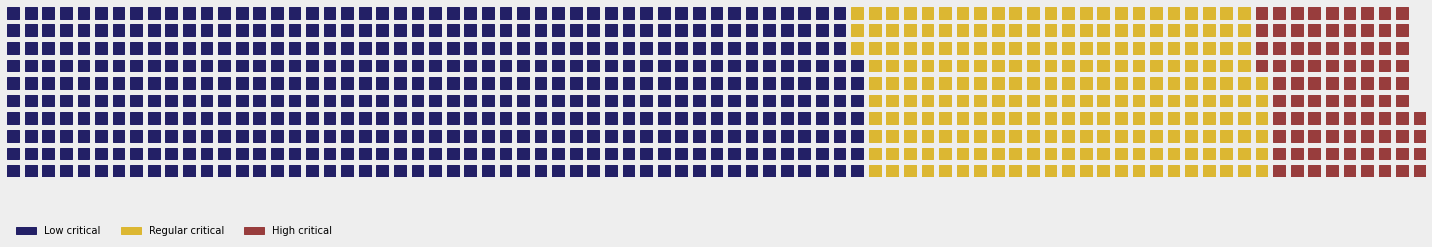

In [30]:
from pywaffle import Waffle

data = {'Low critical': low_critical, 'Regular critical': regular_critical, 'High critical': high_critical}

fig = plt.figure(
    FigureClass=Waffle, 
    rows=10, 
    values=data, 
    colors=("#232066", "#DCB732", "#983D3D"),
    labels=['Low critical', 'Regular critical', 'High critical'],
    legend={'loc': 'lower left', 'bbox_to_anchor': (0, -0.4), 'ncol': len(data), 'framealpha': 0},
    interval_ratio_x=0.5,
    interval_ratio_y=0.5,
    figsize=(20,10)
)
fig.gca().set_facecolor('#EEEEEE')
fig.set_facecolor('#EEEEEE')
plt.show()

In [31]:
data_class = merged_data.copy()

def split_at_last_point(s):
    idx = s.rfind('.')
    return s[:idx], s[idx+1:]
def split_method_name(value):
    parent, method_name = split_at_last_point(value)
    parent, class_name = split_at_last_point(parent)
    return pd.Series([parent, class_name, method_name])

data_class[['Parent_class', 'Class', 'Method']] = data_class['Method'].apply(split_method_name)
data_class

Method   LOC   CC  NP   NV  NEST  \
0                                PreInitialize()  14.0  3.0   0  1.0   1.0   
1                                   Initialize()   1.0  1.0   0  0.0   0.0   
2                               PostInitialize()   2.0  1.0   0  0.0   0.0   
3                     GES_GRTDomainServiceBase()   2.0  1.0   0  0.0   0.0   
4                           GES_GRTServiceBase()   2.0  1.0   0  0.0   0.0   
..                                           ...   ...  ...  ..  ...   ...   
799            RegisterBundles(BundleCollection)   8.0  1.0   1  0.0   0.0   
800      AddAppCssLibs(BundleCollection,Boolean)   1.0  3.0   2  0.0   1.0   
801  AddAppMetronicCss(BundleCollection,Boolean)   1.0  6.0   2  0.0   1.0   
802    SetNavigation(INavigationProviderContext)   2.0  1.0   1  0.0   0.0   
803                                    L(String)   1.0  1.0   1  1.0   0.0   

     Ca  Ce  NChg   NCall   CLevel             Parent_class  \
0     0   2   2.0     4.0  regular                  GES_GRT   
1     0   0   1.0     4.0      low                  GES_GRT   
2     0   1   1.0     4.0      low                  GES_GRT   
3     5   0   1.0  3707.0      low                  GES_GRT   
4     4   0   1.0  2358.0      low                  GES_GRT   
..   ..  ..   ...     ...      ...                      ...   
799   1   3   4.0     4.0  regular  GES_GRT.Web.App.Startup   
800   1   2   1.0     8.0      low  GES_GRT.Web.App.Startup   
801   1   2   1.0     8.0      low  GES_GRT.Web.App.Startup   
802   0   1  17.0     4.0     high  GES_GRT.Web.App.Startup   
803   1   0   2.0    92.0  regular  GES_GRT.Web.App.Startup   

                        Class  
0           GES_GRTCoreModule  
1           GES_GRTCoreModule  
2           GES_GRTCoreModule  
3    GES_GRTDomainServiceBase  
4          GES_GRTServiceBase  
..                        ...  
799           AppBundleConfig  
800           AppBundleConfig  
801           AppBundleConfig  
802     AppNavigationProvider  
803     AppNavigationProvider  

[804 rows x 13 columns]

In [32]:
import plotly.express as px

config = dict({'scrollZoom': True})

fig = px.treemap(data_class, path=['Parent_class', 'Class', 'Method'], values='LOC', color='CLevel',
                  color_discrete_map={'(?)':'black', 'low':'blue', 'regular':'yellow', 'high':'red'})
fig.show(config=config)